In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.binary_models as binary_models
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_binary_dataset as make_binary_dataset
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import plotting.plots as plots
import json

In [3]:
import model.train_profile_model as train_profile_model

### Define paths for the model and data of interest

In [4]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE/profile/config/SPI1/SPI1_training_paths.json"
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_hypertune/12/model_ckpt_epoch_10.pt"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [5]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["train_peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [6]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [7]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [8]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting outputs

In [9]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss), (pos_loss, neg_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, status, input_grads,
            0, 20, 200, 0.5, 160, 1, 3, False
    )
    print("\n%6.3f\t%6.3f\t%6.3f\t%6.3f\t%6.3f\t%6.3f\t%6.3f" % (
        prof_loss.item(), count_loss.item(), pos_loss.item(), neg_loss.item(),
        corr_loss.item(), att_loss.item(), loss.item()
    ))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    # return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_grads.detach().cpu().numpy()
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np

### Computing/plotting Fourier transforms

In [10]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [11]:
def plot_grad_and_fft(grads, include_dc=False, combine_type="relu"):
    assert len(grads.shape) == 2
    
    if combine_type == "relu":
        grads_separate = grads.copy()  # Make a copy
        grads_separate[grads_separate < 0] = 0  # Pass through ReLU
        grads_combined = np.max(grads_separate, axis=1)
    else:
        grads_separate = np.abs(grads)
        grads_combined = np.sum(grads_separate, axis=1)
    
    freqs, mags = dft(grads_combined)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, cut-off gradients, and the DFT
    viz_sequence.plot_weights(grads, subticks_frequency=100)
    viz_sequence.plot_weights(grads_separate, subticks_frequency=100)
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    ax[0].plot(np.arange(len(grads_combined)), grads_combined, color="blue")
    ax[0].set_xlabel("X")
    ax[0].margins(0)
    if combine_type == "relu":
        ax[0].set_ylabel("max(ReLU(grad))")
    else:
        ax[0].set_ylabel("sum(|grad|)")
    ax[1].plot(freqs, mags, color="red")
    ax[1].set_xlabel("Frequency (radians)")
    ax[1].set_ylabel("|Frequency component|")
    ax[1].margins(0)
    plt.tight_layout()
    plt.show(block=False)

### Plotting the input gradients

In [ ]:
# Sample some positive coordinates
pos_coords_table.sample(10)

In [ ]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)


380.384	 0.232	 0.205	 0.000	385.034	 0.205	425.982


findfont: Font family ['Laksaman', 'Verdana', 'Arial'] not found. Falling back to DejaVu Sans.


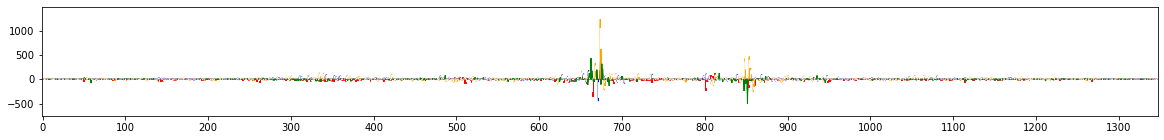

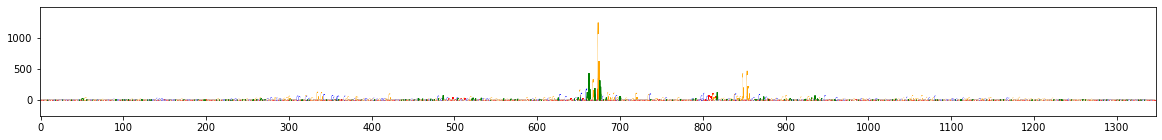

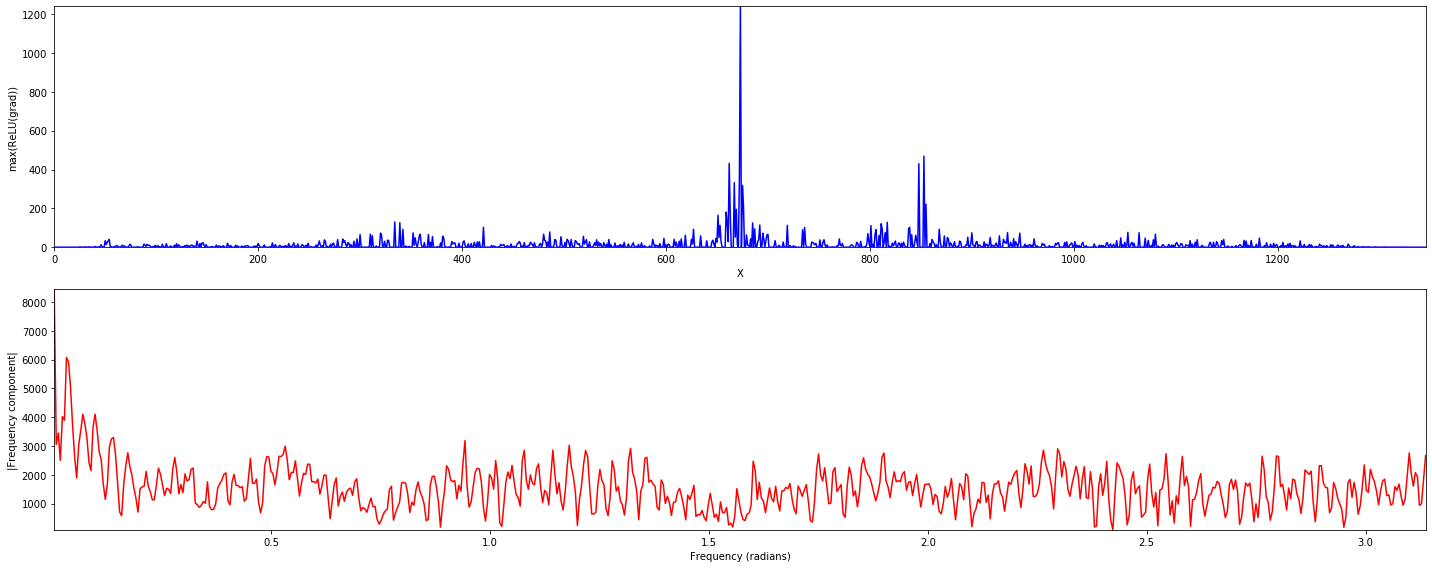

In [12]:
log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads = \
    predict_coords([("chr7", 35728849, 35729849)] * 50)
plot_grad_and_fft(input_grads[0] * input_seqs[0])


182.243	 1.324	 0.194	 0.000	208.727	 0.194	247.504


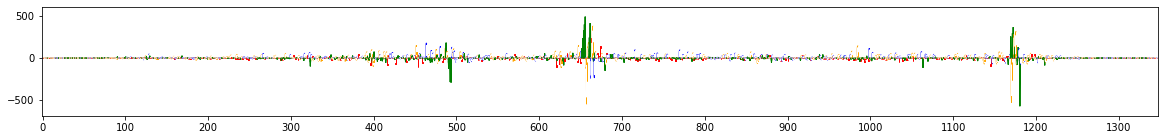

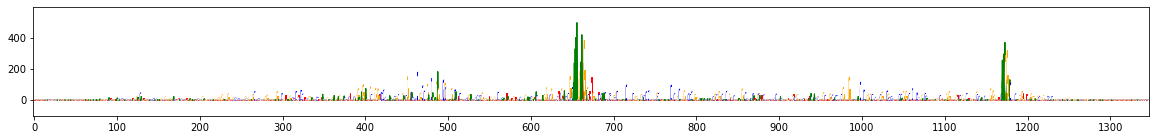

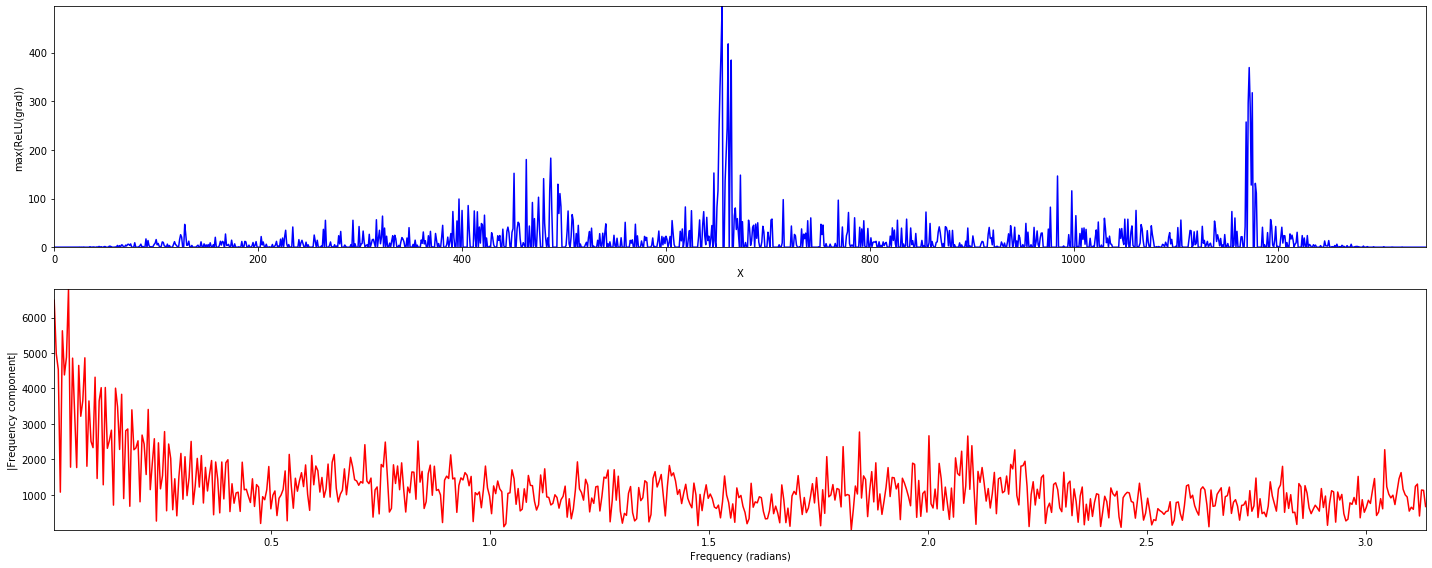

In [13]:
log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads = \
    predict_coords([("chr21", 35867730, 35868730)] * 50)
plot_grad_and_fft(input_grads[0] * input_seqs[0])


155.378	 0.276	 0.208	 0.000	160.888	 0.208	202.463


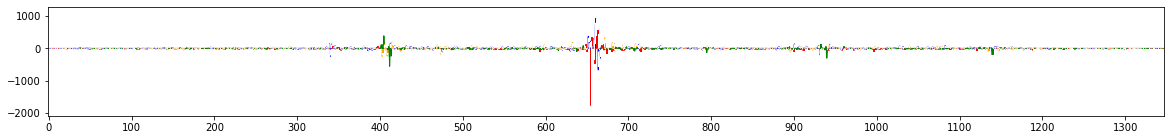

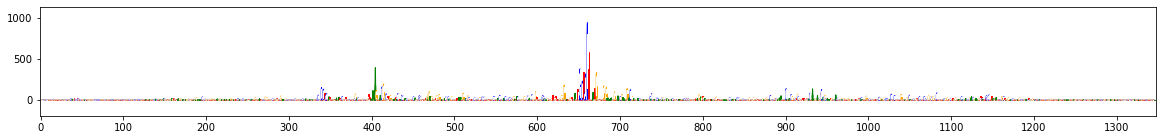

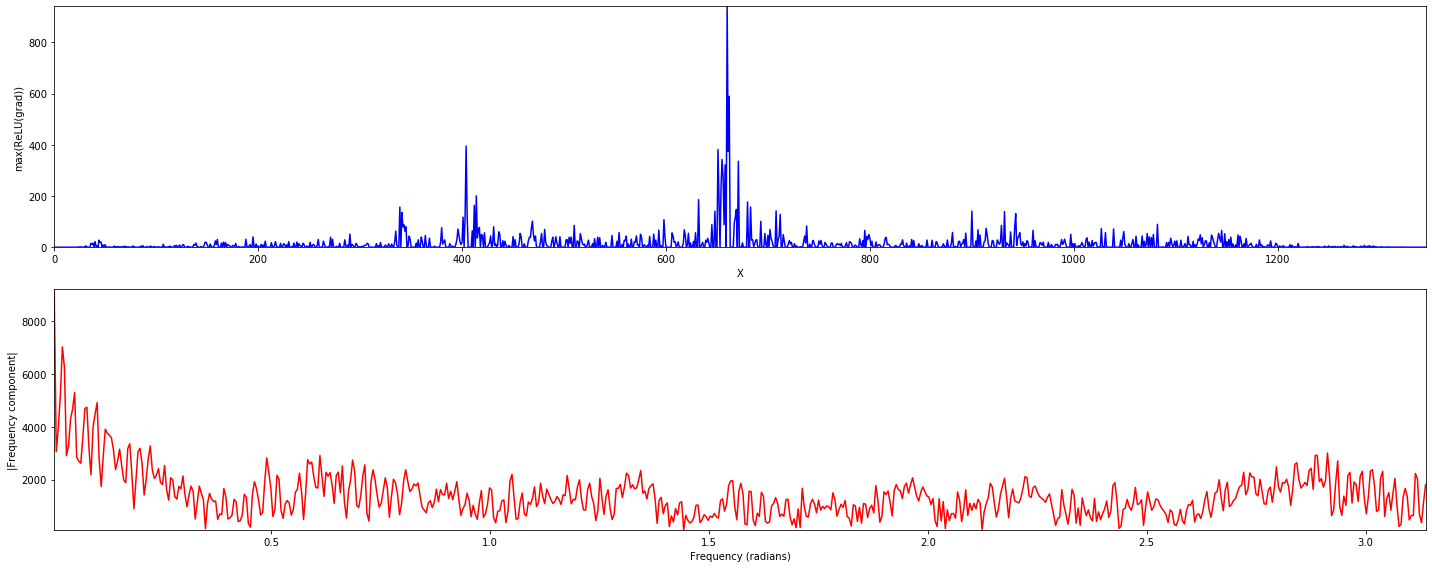

In [14]:
log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads = \
    predict_coords([("chr1", 19390708, 19391708)] * 50)
plot_grad_and_fft(input_grads[0] * input_seqs[0])